In [1]:
# auto-load when code changes outside
%load_ext autoreload
%autoreload 2
%load_ext pyinstrument

import sys
sys.path.insert(0,'..')


In [2]:
#imports 
import os
import nltk
import spacy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.onnx as onnx
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from torch.utils.data import DataLoader,Dataset
from PIL import Image
from tqdm import tqdm
from time import sleep

from src.baseline.vocabulary import Vocabulary
from src.baseline.data_loader import get_loader, get_loaders, get_mean_std
from src.baseline.coa_model import save_model, load_model, get_new_model, validate_model, train_model, train_validate_test_split
from src.utils import print_time, zip_dir_to_file, unzip_file_to_dir, list_of_tensors_to_numpy_arr
from src.pytorchtools import EarlyStopping, EarlyStoppingAccuracy
from src.accuracy import Accuracy

from pyinstrument import Profiler
from datetime import datetime
from shutil import copyfile

# torch.cuda.empty_cache()


## Torch data-loader
https://www.kaggle.com/mdteach/torch-data-loader-flicker-8k

# Split Data into Training/Test datasets 

In [3]:

# data_location = '/home/space/datasets/COA/generated-data-api'
# data_location =  '/home/space/datasets/COA/generated-data-api-small'
# data_location =  '../generated'
data_location =  '../smaller-gen'

caption_file = data_location + '/captions.txt'
root_folder_images = data_location + '/images'
df = pd.read_csv(caption_file)

train, validate, test = train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None)


train_annotation_file = data_location + '/train_captions.txt'
val_annotation_file  = data_location + '/val_captions.txt'
test_annotation_file  = data_location + '/test_captions.txt'

train.to_csv(train_annotation_file, sep=',',index=False)
test.to_csv(test_annotation_file, sep=',',index=False)
validate.to_csv(val_annotation_file, sep=',',index=False)


print("There are {} total images".format(len(df)))

caption_file = data_location + '/train_captions.txt'
df1 = pd.read_csv(caption_file)
print("There are {} train images".format(len(df1)))

caption_file = data_location + '/val_captions.txt'
df2 = pd.read_csv(caption_file)
print("There are {} val images".format(len(df2)))

caption_file = data_location + '/test_captions.txt'
df3 = pd.read_csv(caption_file)
print("There are {} test images".format(len(df3)))

There are 151 total images
There are 90 train images
There are 30 val images
There are 31 test images


Caption: image_1.png A A lion
(500, 500, 4)


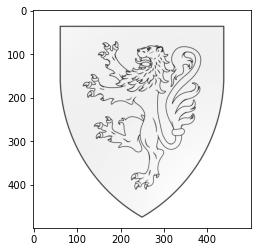

In [4]:
for i in range(1, 2):
    image_path = data_location + '/images/'+ df.iloc[i,0]
    print("Caption:", df.iloc[i,0], df.iloc[i,1])
    img=mpimg.imread(image_path)
    print(img.shape)
    plt.imshow(img)
    plt.show()


In [5]:
!export CUDA_VISIBLE_DEVICES=0
!export CUDA_LAUNCH_BLOCKING=1

In [6]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

device

device(type='cpu')

In [7]:
torch.cuda.get_device_name(0)

AssertionError: Torch not compiled with CUDA enabled

# Image Captioning With Attention - Pytorch

In [21]:
from src.baseline.vocabulary import Vocabulary

# BATCH_SIZE = 5
NUM_WORKER = 2 #### this needs multi-core

#testing the vicab class 
v = Vocabulary(freq_threshold=1)

v.build_vocab([ 'lion','lion rampant', 'lion passt', 'lion passt guard', "lion's head",
                'lions','lions rampant', 'lions passt', 'lions passt guard',
               'cross', 'cross moline', 'cross patonce',
               'eagle', 'eagle doubleheaded', 'eagles', 'eagles doubleheaded',
              'A', 'B', 'O', 'S', 'G', 'E', 'V',
              '1', '2', '3', '4', '5', '6', '7', '8', '9', '10','11',
              'border', '&'])

print(v.stoi)
print(v.numericalize("A lion rampant"))
print(v.itos)


{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'lion': 4, 'rampant': 5, 'passt': 6, 'guard': 7, 'head': 8, 'lions': 9, 'cross': 10, 'moline': 11, 'patonce': 12, 'eagle': 13, 'doubleheaded': 14, 'eagles': 15, 'a': 16, 'b': 17, 'o': 18, 's': 19, 'g': 20, 'e': 21, 'v': 22, '1': 23, '2': 24, '3': 25, '4': 26, '5': 27, '6': 28, '7': 29, '8': 30, '9': 31, '10': 32, '11': 33, 'border': 34, '&': 35}
[16, 4, 5]
{0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'lion', 5: 'rampant', 6: 'passt', 7: 'guard', 8: 'head', 9: 'lions', 10: 'cross', 11: 'moline', 12: 'patonce', 13: 'eagle', 14: 'doubleheaded', 15: 'eagles', 16: 'a', 17: 'b', 18: 'o', 19: 's', 20: 'g', 21: 'e', 22: 'v', 23: '1', 24: '2', 25: '3', 26: '4', 27: '5', 28: '6', 29: '7', 30: '8', 31: '9', 32: '10', 33: '11', 34: 'border', 35: '&'}


In [22]:
# freq_threshold = 5
# # 30 minutes to create those, as it's baseline, i ran it several times and it's the same
# vocab = Vocabulary(freq_threshold)
# vocab.stoi = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'lion': 4, 'rampant': 5, 'passt': 6, 'guard': 7, 'head': 8, 'lions': 9, 'cross': 10, 'moline': 11, 'patonce': 12, 'eagle': 13, 'doubleheaded': 14, 'eagles': 15, 'a': 16, 'b': 17, 'o': 18, 's': 19, 'g': 20, 'e': 21, 'v': 22, '1': 23, '2': 24, '3': 25, '4': 26, '5': 27, '6': 28, '7': 29, '8': 30, '9': 31, '10': 32, '11': 33, 'border': 34, '&': 35}
# vocab.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'lion', 5: 'rampant', 6: 'passt', 7: 'guard', 8: 'head', 9: 'lions', 10: 'cross', 11: 'moline', 12: 'patonce', 13: 'eagle', 14: 'doubleheaded', 15: 'eagles', 16: 'a', 17: 'b', 18: 'o', 19: 's', 20: 'g', 21: 'e', 22: 'v', 23: '1', 24: '2', 25: '3', 26: '4', 27: '5', 28: '6', 29: '7', 30: '8', 31: '9', 32: '10', 33: '11', 34: 'border', 35: '&'}

# old before extending to multi object, plural and border
# vocab.stoi = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'g': 4, 'v': 5, 'b': 6, 'cross': 7, 'lion': 8, 'passt': 9, 's': 10, 'a': 11, 'eagle': 12, 'o': 13, 'doubleheaded': 14, "'s": 15, 'head': 16, 'patonce': 17, 'moline': 18, 'guard': 19, 'rampant': 20}
# vocab.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'g', 5: 'v', 6: 'b', 7: 'cross', 8: 'lion', 9: 'passt', 10: 's', 11: 'a', 12: 'eagle', 13: 'o', 14: 'doubleheaded', 15: "'s", 16: 'head', 17: 'patonce', 18: 'moline', 19: 'guard', 20: 'rampant'}


## Calcualte the mean and std of training dataset

https://deeplizard.com/learn/video/lu7TCu7HeYc

https://discuss.pytorch.org/t/understanding-transform-normalize/21730

In [23]:

print_time('\n ------------------------ \n before DataLoader')
profiler = Profiler(async_mode='disabled')

profiler.start()
train_loader, train_dataset = get_loader(
    root_folder=root_folder_images,
    annotation_file=train_annotation_file,
    transform=None,  # <=======================
    num_workers=NUM_WORKER,
    vocab=vocab,
    batch_size=256,
    device=device,
    pin_memory=False
)

profiler.stop()

profiler.print()

print_time('\n ------------------------ \n after DataLoader')


 ------------------------ 
 before DataLoader @ Time = 19:04:26

  _     ._   __/__   _ _  _  _ _/_   Recorded: 19:04:26  Samples:  262
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.449     CPU time: 0.530
/   _/                      v4.1.1

Program: /Users/salnabulsi/miniconda/envs/thesis-py38/lib/python3.8/site-packages/ipykernel_launcher.py -f /Users/salnabulsi/Library/Jupyter/runtime/kernel-7e73ca76-6fe9-4e67-a7a0-1cbdca910fcb.json

0.449 run_code  IPython/core/interactiveshell.py:3416
└─ 0.449 <module>  ../../../var/folders/0d/kx07xpsn40v0mbjthb6sbc5h0000gq/T/ipykernel_14629/3773756206.py:5
   └─ 0.449 get_loader  src/baseline/data_loader.py:11
      └─ 0.449 __init__  src/baseline/coa_dataset.py:15
         └─ 0.445 load_images  src/baseline/coa_dataset.py:37
            ├─ 0.323 convert  PIL/Image.py:847
            │     [21 frames hidden]  PIL, <built-in>
            │        0.286 ImagingDecoder.decode  <built-in>:0
            ├─ 0.075 __call__  torchvision/transforms/tr

In [24]:
# def get_m(loader):
#     mean = 0.
#     std = 0.
#     for images, _ in loader:
#         batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
#         images = images.view(batch_samples, images.size(1), -1)
#         mean += images.mean(2).sum(0)
#         std += images.std(2).sum(0)

#     mean /= len(loader.dataset)
#     std /= len(loader.dataset)
    
#     return mean, std

In [25]:
# print_time('before')
# mean, std = get_m(train_loader )
# print('mean, std:', mean, std)
# print_time('after')


In [12]:
print_time('\n ------------------------ \n before get_mean_std')

profiler.start()
mean, std = get_mean_std(train_dataset, train_loader, 500 , 500)
print('mean, std:', mean, std)
profiler.stop()

profiler.print()

print_time('\n ------------------------ \n after get_mean_std')



 ------------------------ 
 before get_mean_std @ Time = 19:02:34
mean, std: tensor(0.9687) tensor(1.2960)

  _     ._   __/__   _ _  _  _ _/_   Recorded: 19:02:30  Samples:  402
 /_//_/// /_\ / //_// / //_'/ //     Duration: 6.084     CPU time: 1.168
/   _/                      v4.1.1

Program: /Users/salnabulsi/miniconda/envs/thesis-py38/lib/python3.8/site-packages/ipykernel_launcher.py -f /Users/salnabulsi/Library/Jupyter/runtime/kernel-7e73ca76-6fe9-4e67-a7a0-1cbdca910fcb.json

6.083 run_code  IPython/core/interactiveshell.py:3416
├─ 5.597 <module>  ../../../var/folders/0d/kx07xpsn40v0mbjthb6sbc5h0000gq/T/ipykernel_14629/2842918350.py:4
│  └─ 5.589 get_mean_std  src/baseline/data_loader.py:52
│     ├─ 5.161 __next__  torch/utils/data/dataloader.py:432
│     │     [20 frames hidden]  torch, multiprocessing, selectors, <b...
│     │        4.734 poll.poll  <built-in>:0
│     ├─ 0.298 __iter__  torch/utils/data/dataloader.py:339
│     │     [100 frames hidden]  torch, multiprocessing

In [13]:
#defining the transform to be applied

transform = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize(mean, std) 
])


In [14]:
#Initiate the Dataset and Dataloader
BATCH_SIZE = 256

print_time('writing the dataloader')

train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = get_loaders(
    root_folder=root_folder_images,
    train_annotation_file=train_annotation_file,
    val_annotation_file=val_annotation_file,
    test_annotation_file=test_annotation_file,
    transform=transform,
    num_workers=NUM_WORKER,
    vocab=vocab,
    batch_size=BATCH_SIZE,
    device=device,
    pin_memory=False
)
len(train_loader), len(val_loader), len(test_loader), len(train_dataset), len(val_dataset), len(test_dataset)
print_time('finished writing the dataloader')

writing the dataloader @ Time = 19:02:41
finished writing the dataloader @ Time = 19:02:42


In [15]:
train_dataset.vocab.stoi

{'<PAD>': 0,
 '<SOS>': 1,
 '<EOS>': 2,
 '<UNK>': 3,
 'lion': 4,
 'rampant': 5,
 'passt': 6,
 'guard': 7,
 'head': 8,
 'lions': 9,
 'cross': 10,
 'moline': 11,
 'patonce': 12,
 'eagle': 13,
 'doubleheaded': 14,
 'eagles': 15,
 'a': 16,
 'b': 17,
 'o': 18,
 's': 19,
 'g': 20,
 'e': 21,
 'v': 22,
 '1': 23,
 '2': 24,
 '3': 25,
 '4': 26,
 '5': 27,
 '6': 28,
 '7': 29,
 '8': 30,
 '9': 31,
 '10': 32,
 '11': 33,
 'border': 34,
 '&': 35}

# Defining the Model Architecture

Model is seq2seq model. In the **encoder** pretrained ResNet model is used to extract the features. Decoder, is the implementation of the Bahdanau Attention Decoder. In the decoder model **LSTM cell**.

https://blog.floydhub.com/attention-mechanism/

https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/
    

### Setting Hypperparameter and Init the model

In [16]:
train_dataset.vocab.stoi["<PAD>"]

0

In [17]:
#Hyperparams
embed_size=300
vocab_size = len(train_dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4
drop_prob=0.3
ignored_idx = train_dataset.vocab.stoi["<PAD>"]

hyper_params = {'embed_size': embed_size,
                'attention_dim': attention_dim,
                'encoder_dim': encoder_dim,
                'decoder_dim': decoder_dim,
                'vocab_size': vocab_size
              }

In [30]:

#initialize new model, loss etc
model, optimizer, criterion = get_new_model(hyper_params, learning_rate, ignored_idx, drop_prob, device)

## Training Job from above configs

In [31]:
!export CUDA_LAUNCH_BLOCKING=1
!export CUDA_VISIBLE_DEVICES=2

## Train the Model using Early Stopping


In [32]:

batch_size = 256
n_epochs = 2

# early stopping patience; how long to wait after last time validation loss improved.
patience = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device is {device}')

model, train_loss, valid_loss, avg_acc, bleu_score = train_model(model, optimizer, criterion, train_loader, val_loader, val_dataset, vocab_size, batch_size, patience, n_epochs, device)


device is cpu


Epoch 1: 100%|█████████████████████████████████████████████████████████| 1/1 [00:28<00:00, 28.37s/batch, Train loss (in progress)=3.58]


[1/2] train_loss: 3.57678 , valid_loss: 3.23258 , accuracy: 0.00000
Accuracy increased (0.000000 --> 0.000000).  Saving model ...


Epoch 2: 100%|█████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.80s/batch, Train loss (in progress)=3.11]
/Users/salnabulsi/miniconda/envs/thesis-py38/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


[2/2] train_loss: 3.11338 , valid_loss: 2.89782 , accuracy: 0.00000
Accuracy increased (0.000000 --> 0.000000).  Saving model ...


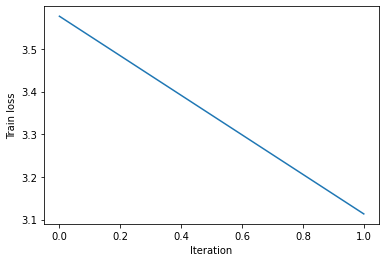

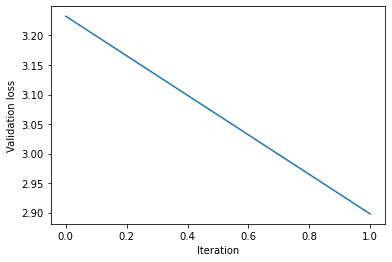

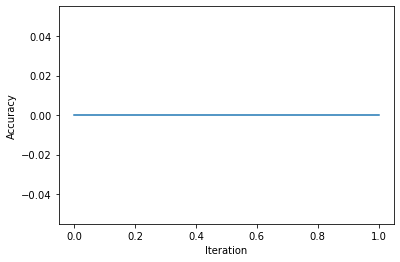

In [33]:
plt.plot(train_loss)
plt.xlabel("Iteration")
plt.ylabel("Train loss")
plt.show()

plt.plot(valid_loss)
plt.xlabel("Iteration")
plt.ylabel("Validation loss")
plt.show()

plt.plot(avg_acc)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

In [39]:
model.cpu()
model_state = {
    'hyper_params': hyper_params,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_loss,
    'accuracy': avg_acc
}

torch.save(model_state, '../test-save.pt')


In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ignored_idx = train_dataset.vocab.stoi["<PAD>"]

model, optimizer, criterion = get_new_model(hyper_params, learning_rate, ignored_idx, drop_prob, device)

checkpoint = torch.load('../test-save.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss = checkpoint['loss']
accuracy = checkpoint['loss']

## Visualizing the Accuracy (and loss) and the Early Stopping Checkpoint


In [19]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')

# valid_loss_arr = list_of_tensors_to_numpy_arr(valid_loss)
plt.plot(range(1,len(valid_loss)+1),valid_loss, label='Validation Loss')

# find position of lowest validation loss
# minposs = valid_loss.index(min(valid_loss))+1 
# plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

# find position of lowest validation loss
maxposs = avg_acc.index(max(avg_acc))-1 
plt.axvline(maxposs, linestyle='--', color='r',label='Early Stopping Checkpoint - Accuracy')

plt.plot(range(1,len(avg_acc)+1),avg_acc,label='Accuracy')

plt.xlabel('epochs')
plt.ylabel('loss')
# plt.ylim(0, 0.5) # consistent scale
# plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')


NameError: name 'train_loss' is not defined

<Figure size 720x576 with 0 Axes>

# Test the Trained Network


In [30]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
test_losses=[]
accuracy_test_list=[]

model.eval()
with torch.no_grad():
    for idx, (img, correct_cap) in enumerate(iter(test_loader)):
        features = model.encoder(img.to(device))

        features_tensors = img[0].detach().clone().unsqueeze(0)
        features = model.encoder(features_tensors.to(device))

        caps,_ = model.decoder.generate_caption(features, vocab=val_dataset.vocab)   
        caps = caps[:-1]
        predicted_caption = ' '.join(caps)
        print(predicted_caption)
        # compare predictions to true label
        correct_caption = []
        for j in correct_cap.T[0]:
            if j.item() not in [0, 1, 2 , 3]:
                correct_caption.append(val_dataset.vocab.itos[j.item()])
        correct_caption_s = ' '.join(correct_caption)
        
        # calc metrics
        acc_test = Accuracy(predicted_caption,correct_caption_s).get()
        accuracy_test_list.append(acc_test)
        print(f'Test Acuuracy (in progress): {acc_test:.6f}\n')

        # ------------------------------------------
        # calc losses and take the average 
        image, captions = img.to(device), correct_cap.to(device)
        outputs, _ = model(image, captions.T)
        targets    = captions.T[:,1:] 
        loss       = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        test_losses.append(loss)

        # ------------------------------------------

# calculate and print avg test loss
test_loss = sum(test_losses)/len(test_dataset)
print('Test Loss (final): {:.6f}\n'.format(test_loss))

acc_test_score = (100. * sum(accuracy_test_list) / len(accuracy_test_list))

print(f'Test Accuracy (Overall): {acc_test_score}%')


1 1 & e e 5 e 5 e 5 e 5 e 5 e 5 e 5 e
Test Acuuracy (in progress): 0.000000

Test Loss (final): 0.115446

Test Accuracy (Overall): 0.0%


##  Visualizing the attentions
Defining helper functions
<li>Given the image generate captions and attention scores</li>
<li>Plot the attention scores in the image</li>

In [31]:
#generate caption
def get_caps_from(model, features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=test_dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas
#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()
    
def test_rand_image(model, test_loader):
    dataiter = iter(test_loader)
    images,_ = next(dataiter)

    img = images[0].detach().clone()
    img1 = images[0].detach().clone()
    caps,alphas = get_caps_from(model, img.unsqueeze(0))

    plot_attention(img1, caps, alphas)

    #show the tensor image
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
      
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


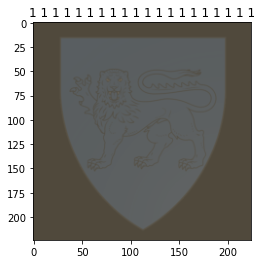

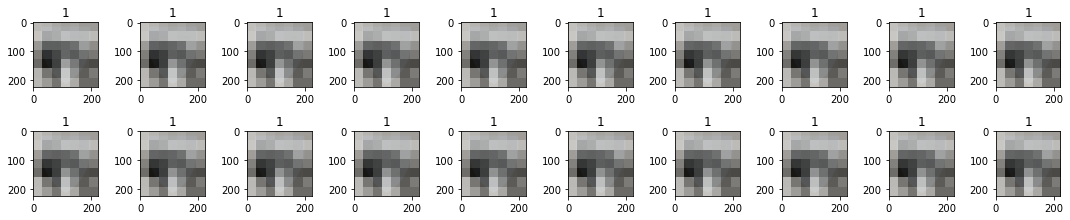

In [32]:
# torch.cuda.empty_cache()

# model_path = '/home/space/datasets/COA/models/baseline/attention_model_state.pth'
# local_model_path = 'simple-model.pth'
# model = load_model(local_model_path)
test_rand_image(model,test_loader)